# Strokes Gained Putting Research

In [8]:
import sqlite3
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

conn = sqlite3.connect('/Users/nickospelt/Documents/App_Projects/PGA_Tournament_Winner/Data/PGA_SQL_DB/PGA.db')

## Pull Strokes Gained Putting Historical Metrics
- Using metrics brainstormed and calculated in PGA_SQL_DB/SG_P.py

In [9]:
df = pd.read_sql_query("SELECT * FROM SG_P_EDA", conn)
df = df.dropna()
df

,TOURNAMENT_NAME,PLAYER_NAME,TOURNAMENT_DATE,ADJ_SG_P,SG_P,POSITION,STD_ADJ_SG_P,STD_SG_P,ADJ_SG_P_1,SG_P_1,...,DAYS_4,ADJ_SG_P_5,SG_P_5,DAYS_5,T5_AVG_ADJ_SG_P,T5_AVG_SG_P,T12_AVG_ADJ_SG_P,T12_AVG_SG_P,T12_SG_PUTT,T12_APPERANCES
5,2023 THE PLAYERS Championship,Aaron Baddeley,2023-03-09 00:00:00,-0.50125,-0.768823,72.0,0.793708,0.722200,1.250764,1.44875,...,1484.0,-0.375810,0.02150,1729.0,0.365603,0.66135,1.250764,1.448750,1.0,1.0
6,2022 Valero Texas Open,Aaron Baddeley,2022-03-31 00:00:00,1.44875,1.250764,18.0,0.745368,0.683981,0.915880,1.15000,...,1386.0,-0.700594,-0.28450,1442.0,-0.024668,0.31470,0.915880,1.150000,1.0,1.0
11,2020 Waste Management Phoenix Open,Aaron Baddeley,2020-01-30 00:00:00,-0.37000,-0.747659,40.0,0.696507,0.639403,0.784842,1.05650,...,826.0,0.878792,1.19375,994.0,0.164671,0.49725,0.784842,1.056500,1.0,4.0
31,2024 John Deere Classic,Aaron Rai,2024-07-04 00:00:00,2.22950,1.946159,7.0,0.625556,0.569637,0.416436,0.70700,...,91.0,-0.426514,-0.21025,112.0,-0.348774,-0.04310,-0.430719,-0.127583,6.0,6.0
32,2024 U.S. Open,Aaron Rai,2024-06-13 00:00:00,0.70700,0.416436,19.0,0.626847,0.564656,-1.235779,-0.77025,...,91.0,-0.840445,-0.55000,245.0,-0.600150,-0.29450,-0.451366,-0.151083,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11726,2019 Valspar Championship,Zach Johnson,2019-03-21 00:00:00,0.36525,0.101546,24.0,0.730949,0.772508,1.112275,1.42200,...,336.0,0.410867,0.74275,588.0,0.543650,0.83465,0.576846,0.857625,4.0,8.0
11728,2018 PGA Championship,Zach Johnson,2018-08-09 00:00:00,1.42200,1.112275,19.0,0.670619,0.721092,0.372764,0.37275,...,364.0,-0.012831,0.44375,420.0,0.318629,0.63900,0.401494,0.687812,4.0,7.0
11729,2018 WGC-Bridgestone Invitational,Zach Johnson,2018-08-02 00:00:00,0.37275,0.372764,17.0,0.704481,0.778077,0.234190,0.63150,...,413.0,-1.189391,-1.02525,427.0,0.006198,0.35940,0.411071,0.792833,3.0,6.0
11731,2018 U.S. Open,Zach Johnson,2018-06-14 00:00:00,0.63150,0.234190,12.0,0.757745,0.835342,0.588156,1.00425,...,378.0,-0.924458,-0.60950,399.0,-0.225531,0.11120,0.328731,0.730250,3.0,6.0


## Correlation Analysis

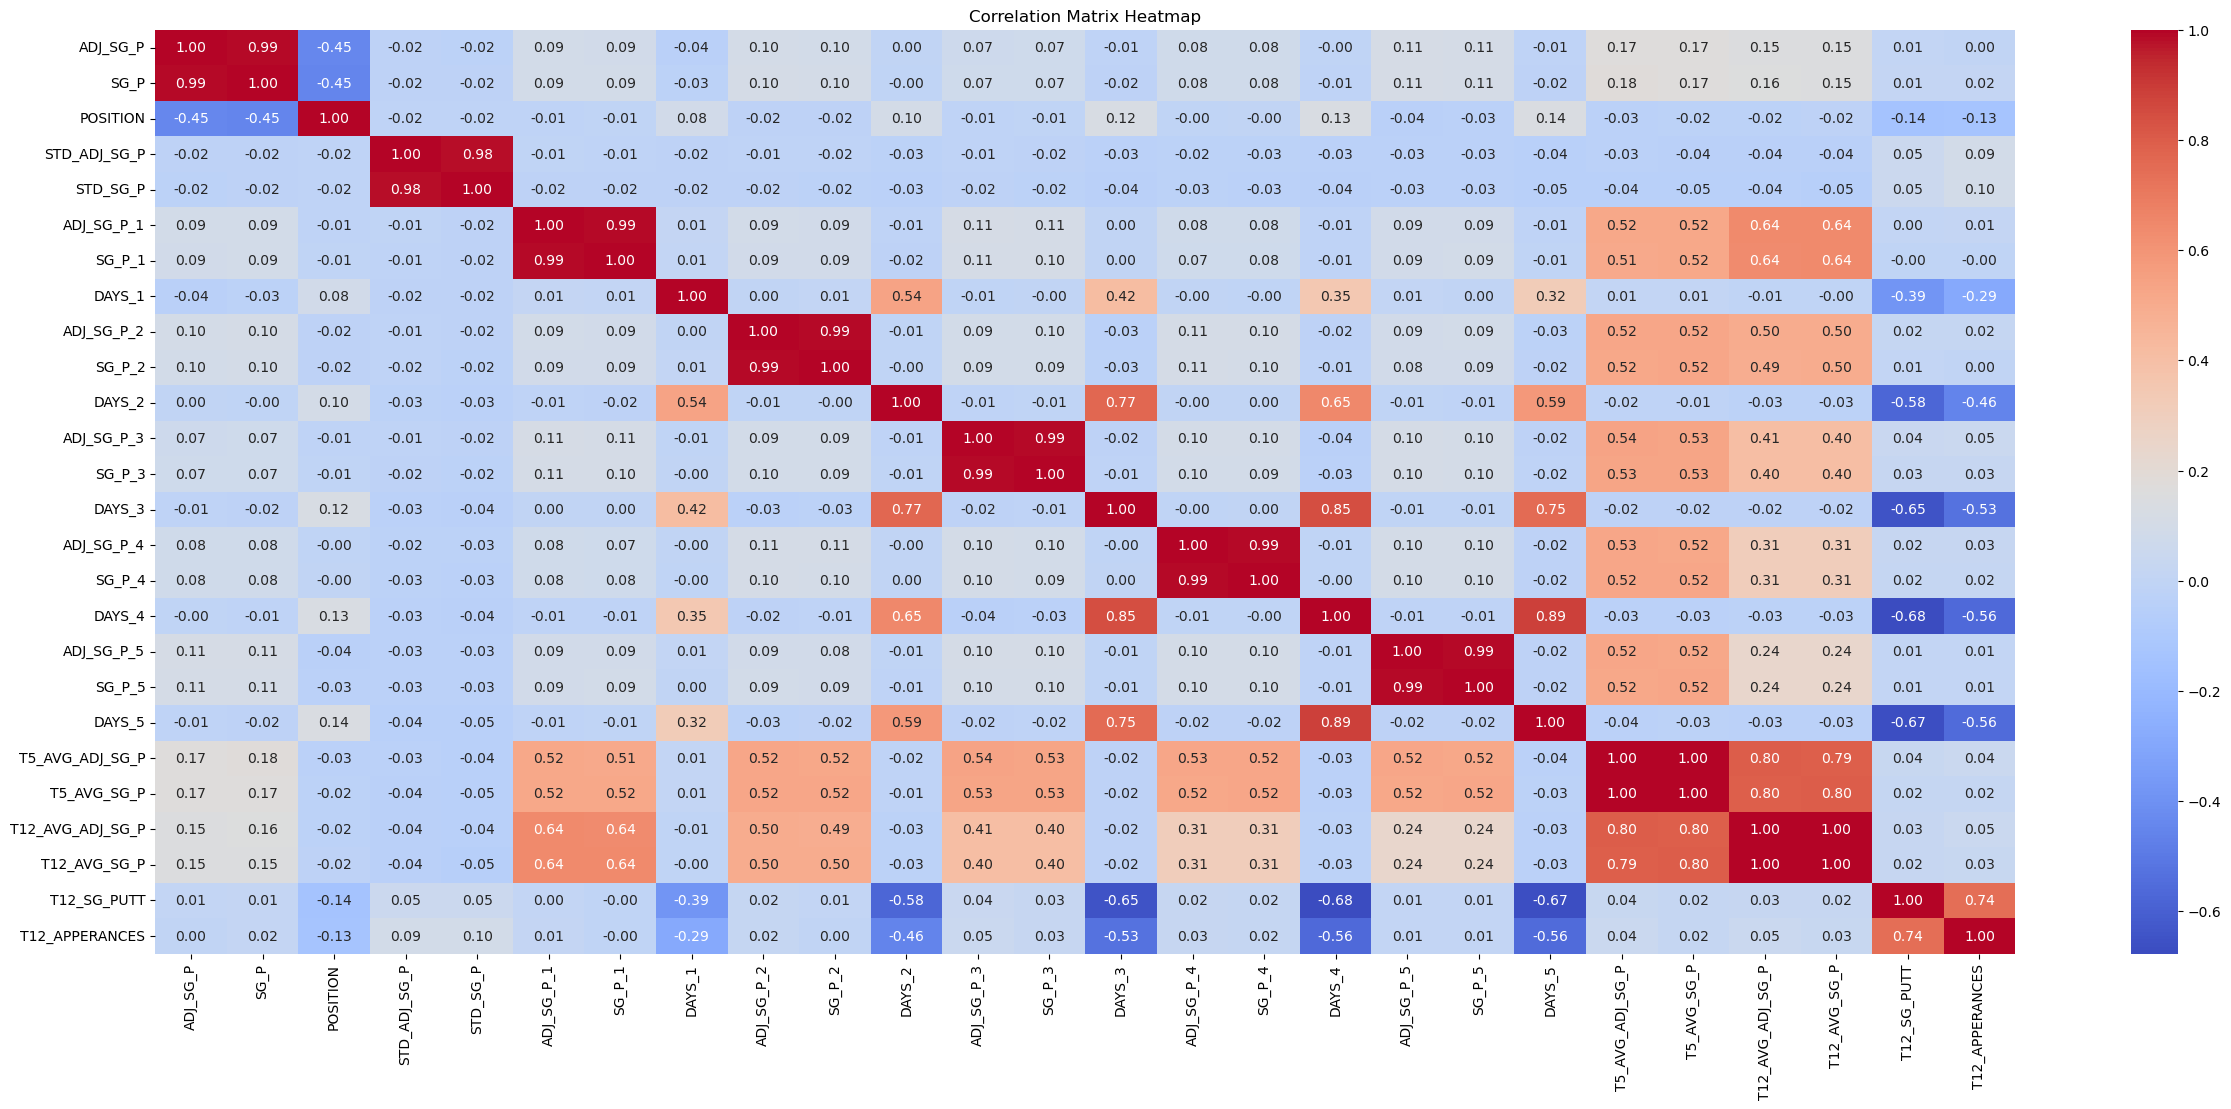

In [10]:
# Compute correlation matrix
correlation_matrix = df[['ADJ_SG_P', 'SG_P',
       'POSITION', 'STD_ADJ_SG_P', 'STD_SG_P', 'ADJ_SG_P_1', 'SG_P_1',
       'DAYS_1', 'ADJ_SG_P_2', 'SG_P_2', 'DAYS_2', 'ADJ_SG_P_3', 'SG_P_3',
       'DAYS_3', 'ADJ_SG_P_4', 'SG_P_4', 'DAYS_4', 'ADJ_SG_P_5', 'SG_P_5',
       'DAYS_5', 'T5_AVG_ADJ_SG_P', 'T5_AVG_SG_P', 'T12_AVG_ADJ_SG_P',
       'T12_AVG_SG_P', 'T12_SG_PUTT', 'T12_APPERANCES']].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(30, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [14]:
std_corr, std_p_value = pearsonr((df['DAYS_1'] + df['DAYS_2'] + df['DAYS_3'] + df['DAYS_4'] + df['DAYS_5']) / 5, df['STD_SG_P'])
adj_std_corr, adj_p_value = pearsonr((df['DAYS_1'] + df['DAYS_2'] + df['DAYS_3'] + df['DAYS_4'] + df['DAYS_5']) / 5, df['STD_ADJ_SG_P'])

print(f"DAYS_1 vs STD_SG_P; Correlation: [{std_corr}], p-value: [{std_p_value}]")
print(f"DAYS_1 vs STD_ADJ_SG_P; Correlation: [{adj_std_corr}], p-value: [{adj_p_value}]")

DAYS_1 vs STD_SG_P; Correlation: [-0.043986053667226827], p-value: [0.011897650571449205]
DAYS_1 vs STD_ADJ_SG_P; Correlation: [-0.03944854248092889], p-value: [0.024102437990412617]


## Develop a Model To Predict Strokes Gained Values
- Tree Based Regression Models
- Support Vector Regression
- Generalized Additive Models (GAMs)